#Install Dependencies & Mount Google Drive

In [ ]:
# Necessary Libraries
!pip install pandas tensorflow transformers scikit-learn numpy matplotlib seaborn imbalanced-learn openpyxl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import Libraries
- Set Random Seed for Reproducibility
- Define Custom Dataset Class

In [ ]:
import random
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_scheduler
from tqdm import tqdm
import torch.nn as nn
from torch.optim import AdamW

# Set Random Seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Dataset Class
class ERDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.float),
        }

#Load Journal Dataset with 5 Emotion Regulation (ER) Categories, plus 'Adaptive' & 'Maladaptive' labels (excluding None) - 7 Labels
- Process Labels (Multi-Label Binarization & Adaptive Labels)
- Train-Test Split
- Load Tokenizer & Create DataLoaders

In [ ]:
# Load Dataset
file_path = "/content/drive/MyDrive/Team_Project/PreTrained_Models_Files/NewDataset_Journal.xlsx"
df = pd.read_excel(file_path)

# Filter out rows with missing values in `final_label`
df = df[df['final_label'].notna()]

# Clean the labels by stripping spaces
df['er_labels'] = df['final_label'].apply(lambda x: [label.strip() for label in x.split(",")])# Remove spaces and split labels

# Prepare Labels
mlb = MultiLabelBinarizer()
er_labels = mlb.fit_transform(df['er_labels'])

# Process adaptive as two binary labels: adaptive (1, 0) and maladaptive (0, 1)
df['adaptive_binary'] = df['Adaptive'].apply(
    lambda x: [1, 0] if x == "adaptive" else [0, 1] if x == "maladaptive" else [0, 0]
)
adaptive_labels = np.array(df['adaptive_binary'].tolist())

# Combine all labels: 6 er_strat + 2 adaptive/maladaptive
combined_labels = np.hstack([er_labels, adaptive_labels])
all_labels = list(mlb.classes_) + ["adaptive", "maladaptive"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df['text_ner'], combined_labels, test_size=0.3, random_state=42
)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Dataset and DataLoader
max_length = 128
batch_size = 16

train_dataset = ERDataset(X_train.tolist(), y_train, tokenizer, max_length)
test_dataset = ERDataset(X_test.tolist(), y_test, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

<ipython-input-5-13abc8a7f90e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['er_labels'] = df['final_label'].apply(lambda x: [label.strip() for label in x.split(",")])# Remove spaces and split labels
<ipython-input-5-13abc8a7f90e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['adaptive_binary'] = df['Adaptive'].apply(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugg

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
print(all_labels)

['Attentional Deployment', 'Cognitive Change', 'Response Modulation', 'Situation Modification', 'Situation Selection', 'adaptive', 'maladaptive']


#Load BERT Model for Multi-Label Classification
- Define Loss Function with Class Weights
- Define Optimizer & Scheduler

In [ ]:
#Load BERT Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=combined_labels.shape[1],
    problem_type="multi_label_classification",
    ignore_mismatched_sizes=True  # Fix mismatch between label sizes
)
model = model.to(device)

# Loss Function with Class Weights
class_counts = np.sum(y_train, axis=0)
pos_weights = torch.tensor((len(y_train) - class_counts) / class_counts, dtype=torch.float).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

# Optimizer and Scheduler
from torch.optim import AdamW
epochs = 10
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * epochs
num_warmup_steps = int(0.1 * num_training_steps)
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Save paths of Best model and Best tokenizer

In [ ]:
# Save Paths For Future Use like for Prediction
model_save_path = "/content/drive/MyDrive/Team_Project/PreTrained_Models_Files/journal_bert_model_7classes.pth"
tokenizer_save_path = "/content/drive/MyDrive/Team_Project/PreTrained_Models_Files/journal_bert_tokenizer_7classes"


#Define Training Function
- Define Evaluation Function
- Training Loop & Save Best Model

In [ ]:
# Training Function
def train_model(model, data_loader, optimizer, loss_fn, scheduler, device):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

# Evaluation Function
def evaluate_model(model, data_loader, device, threshold=0.5):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.sigmoid(logits).cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    return (np.array(predictions) > threshold).astype(int), np.array(true_labels)

# Training Loop
best_f1 = 0
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss = train_model(model, train_loader, optimizer, loss_fn, scheduler, device)
    print(f"Train Loss: {train_loss:.4f}")
    predictions, true_labels = evaluate_model(model, test_loader, device)
    f1 = f1_score(true_labels, predictions, average="macro")
    print(f"Validation F1 Score: {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), model_save_path)
        tokenizer.save_pretrained(tokenizer_save_path)
        print(f"Model and tokenizer saved at {model_save_path}")

Epoch 1/10


100%|██████████| 20/20 [00:07<00:00,  2.65it/s]


Train Loss: 0.9676
Validation F1 Score: 0.3055
Model and tokenizer saved at /content/drive/MyDrive/Team_Project/PreTrained_Models_Files/journal_bert_model_7classes.pth
Epoch 2/10


100%|██████████| 20/20 [00:06<00:00,  2.97it/s]


Train Loss: 0.9725
Validation F1 Score: 0.3107
Model and tokenizer saved at /content/drive/MyDrive/Team_Project/PreTrained_Models_Files/journal_bert_model_7classes.pth
Epoch 3/10


100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


Train Loss: 0.9330
Validation F1 Score: 0.2727
Epoch 4/10


100%|██████████| 20/20 [00:06<00:00,  2.91it/s]


Train Loss: 0.8707
Validation F1 Score: 0.4003
Model and tokenizer saved at /content/drive/MyDrive/Team_Project/PreTrained_Models_Files/journal_bert_model_7classes.pth
Epoch 5/10


100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


Train Loss: 0.7318
Validation F1 Score: 0.4709
Model and tokenizer saved at /content/drive/MyDrive/Team_Project/PreTrained_Models_Files/journal_bert_model_7classes.pth
Epoch 6/10


100%|██████████| 20/20 [00:06<00:00,  2.91it/s]


Train Loss: 0.5979
Validation F1 Score: 0.4799
Model and tokenizer saved at /content/drive/MyDrive/Team_Project/PreTrained_Models_Files/journal_bert_model_7classes.pth
Epoch 7/10


100%|██████████| 20/20 [00:06<00:00,  2.86it/s]


Train Loss: 0.4780
Validation F1 Score: 0.4904
Model and tokenizer saved at /content/drive/MyDrive/Team_Project/PreTrained_Models_Files/journal_bert_model_7classes.pth
Epoch 8/10


100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


Train Loss: 0.4098
Validation F1 Score: 0.4892
Epoch 9/10


100%|██████████| 20/20 [00:07<00:00,  2.77it/s]


Train Loss: 0.3579
Validation F1 Score: 0.4680
Epoch 10/10


100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


Train Loss: 0.3337
Validation F1 Score: 0.4948
Model and tokenizer saved at /content/drive/MyDrive/Team_Project/PreTrained_Models_Files/journal_bert_model_7classes.pth


#Load Best Model & Final Evaluation

In [ ]:
# Load Model for Final Evaluation on Test Set
model.load_state_dict(torch.load(model_save_path, map_location=device))
tokenizer = BertTokenizer.from_pretrained(tokenizer_save_path)
model.to(device)
model.eval()
predictions, true_labels = evaluate_model(model, test_loader, device)
print("Final Evaluation on Test Set")
print(classification_report(true_labels, predictions, target_names=all_labels))

Final Evaluation on Test Set
                        precision    recall  f1-score   support

Attentional Deployment       0.55      0.60      0.57        58
      Cognitive Change       0.54      0.63      0.58        49
   Response Modulation       0.31      0.54      0.39        26
Situation Modification       0.38      0.45      0.42        11
   Situation Selection       0.12      0.14      0.13        14
              adaptive       0.87      0.80      0.83       104
           maladaptive       0.54      0.52      0.53        29

             micro avg       0.58      0.64      0.61       291
             macro avg       0.47      0.53      0.49       291
          weighted avg       0.61      0.64      0.62       291
           samples avg       0.59      0.64      0.60       291



#Classification Report Using HeatMap

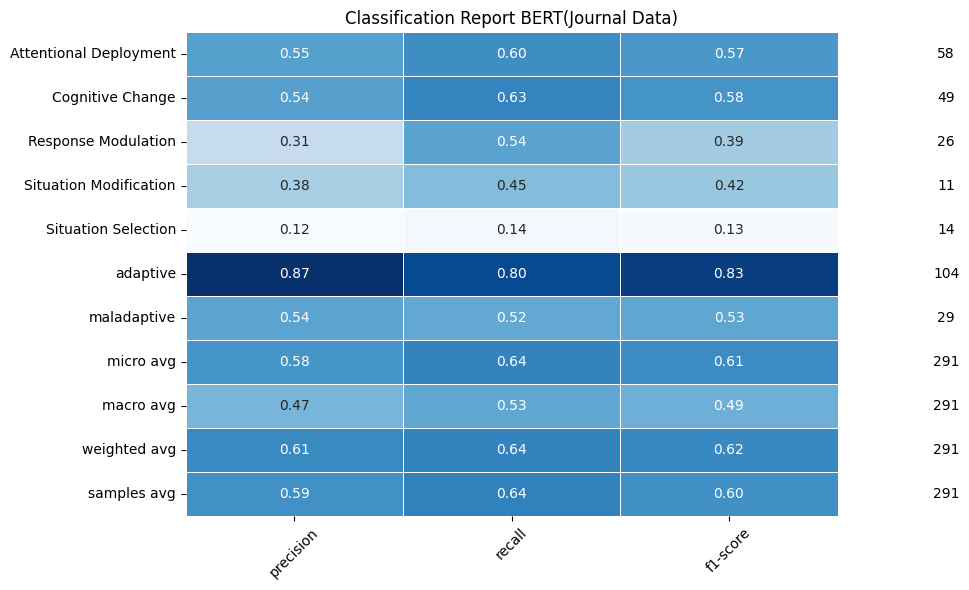

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate classification report as a dictionary
report_dict = classification_report(true_labels, predictions, target_names=all_labels, output_dict=True)

# Convert to a DataFrame
df_report = pd.DataFrame(report_dict).T

# Separate the metrics and support
df_metrics = df_report.drop(columns=['support'])
df_support = df_report['support']

# Plot heatmap for metrics
plt.figure(figsize=(10, 6))
sns.heatmap(df_metrics, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5, cbar=False)

# Add support count as text annotations
for i, support in enumerate(df_support):
    plt.text(len(df_metrics.columns) + 0.5, i + 0.5, f"{int(support)}", ha='center', va='center')

plt.title("Classification Report BERT(Journal Data)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Team_Project/PreTrained_Models_Files/classification_report_heatmap_bertjournal_7classes.png")
plt.show()
